# An illustrative example

## 1D Inverse Heat Equation

An illustrative example is the inversion for the initial condition for a one-dimensional heat equation.

Specifically, we consider a rod of lenght $L$, and let $u(x,t)$ denote the temperature of the rod at point $x$ and time $t$. 
 We are interested in reconstructing the initial temperature profile $m(x) = u(x, 0)$ given some noisy measurements $d$ of the temperature profile at a later time $T$.

### Forward problem

Given
- the initial temperature profile $u(x,0) = m(x)$,
- the thermal diffusivity $k$,
- a prescribed temperature $u(0,t) = u(L,t) = 0$ at the extremities of the rod;

solve the heat equation

$$
\left\{
\begin{array}{ll}
\frac{\partial u}{\partial t} - k \frac{\partial^2}{\partial x^2} u = 0 & \forall x\,\in\,(0, L)\; \forall t \in (0,T)\\
u(x, 0) = m(x) & \forall x \in [0,L] \\
u(0,t) = u(L,t) = 0 & \forall t \in (0, T],
\end{array}
\right.
$$

and observe the temperature at the final time $T$:

$$ \mathcal{F}(m) = u(x, T). $$

#### Analytical solution to the forward problem.
Verify that if

$$ m(x) = \sin\left(n\, \frac{\pi}{L} x \right), \quad n = 1,2,3, \ldots ,$$

then

$$ u(x,t) = e^{ -k\left(n\, \frac{\pi}{L} \right)^2 t} \sin\left(n\,\frac{\pi}{L} x \right) $$

is the unique solution to the heat equation.

### Inverse problem

Given the forward model $\mathcal{F}$ and a noisy measurament $d$ of the temperature profile at time $T$, find the initial temperature profile $m$ such that

$$ \mathcal{F}(m) = d. $$

### Ill-posedness of the inverse problem

Consider a perturbation

$$ \delta m(x) = \varepsilon \sin\left(n \, \frac{\pi}{L} x \right), $$

where $\varepsilon > 0$ and $n = 1, 2, 3, \ldots$.

Then, by linearity of the forward model $\mathcal{F}$, the corresponding perturbation $\delta d(x) = \mathcal{F}(m + \delta m) - \mathcal{F}(m)$ is

$$ \delta d(x) = \varepsilon\, e^{ -k\left(n \, \frac{\pi}{L}\right)^2 T} \sin\left(n \, \frac{\pi}{L} x \right),$$

which converges to zero as $n \rightarrow +\infty$.

Hence the ratio between $\delta m$ and $\delta d$ can become arbitrary large, which shows that the stability requirement for well-posedness can not be satisfied.

### Discretization

To discretize the problem, we use finite differences in space and Implicit Euler in time.

#### Semidiscretization in space
We divide the $[0, L]$ interval in $n_x$ subintervals of the same lenght $h = \frac{L}{n_x}$, and we denote with $u_j(t) := u( jh, t)$ the value of the temperature at point $x_j = jh$ and time $t$.

We then use a centered finite difference approximation of the second derivative in space and write

$$ \frac{\partial u_j(t)}{\partial t} - k \frac{u_{j-1}(t) - 2u_j(t) + u_{j+1}(t)}{h^2} \quad \text{for } j=1,2,\ldots,n_x-1,$$

with the boundary condition $u_0(t) = u_{n_x}(t) = 0$.

By letting

$$ \mathbf{u}(t) = \begin{bmatrix}u_1(t)\\u_2(t)\\ \ldots\\ u_{n_x-1}(t) \end{bmatrix}$$

be the vector collecting the values of the temperature $u$ at the points $x_j = j\,h$, we then write the system of ordinary differential equations (ODEs):
$$ \frac{\partial}{\partial t} \mathbf{u}(t) + K \mathbf{u}(t) = 0,$$
where $K \in \mathbb{R}^{(n_x-1) \times (n_x-1)}$ is the tridiagonal matrix given by

$$ K = \frac{k}{h^2}\begin{bmatrix}  2 & -1 &       &        &        &    \\
                                    -1 &  2 & -1    &        &        &    \\
                                       & -1 &  2    & -1     &        &    \\
                                       &    &\ldots & \ldots & \ldots &    \\
                                       &    &       & -1     &     2  & -1 \\ 
                                       &    &       &        &     -1 & 2  \\
                     \end{bmatrix}.$$
                     
#### Time discretization
We subdivide the time interval $(0, T]$ in $n_t$ time step of size $\Delta t = \frac{T}{n_t}$.
By letting $\mathbf{u}^{(i)} = \mathbf{u}(i\,\Delta t)$ denote the discretized temperature profile at time $t_i = i\,\Delta t$, the Implicit Euler scheme reads

$$ \frac{\mathbf{u}^{(i+1)} - \mathbf{u}^{(i)}}{\Delta t} + K\mathbf{u}^{(i+1)} = 0, \quad \text{for } i=0,1,\ldots, n_t-1.$$

After simple algebraic manipulations and exploiting the initial condition $u(x,0) = m(x)$, we then obtain

$$
\left\{
\begin{array}
\mathbf{u}^{(0)} = \mathbf{m} \\
\mathbf{u}^{(i+1)} = \left( I + \Delta t\, K\right)^{-1} \mathbf{u}^{(i)},
\end{array}
\right.
$$

or equivalently

$$ \mathbf{u}^{(i)} = \left( I + \Delta t\, K\right)^{-i} \mathbf{m}.$$

In the code below, the function `assembleMatrix` generates the finite difference matrix $\left( I + \Delta t\, K \right)$ and the function `solveFwd` evaluates the forward model

$$ F\, \mathbf{m} = \left( I + \Delta t\, K\right)^{-n_t}\, \mathbf{m}. $$

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from IPython.display import HTML

# mpl.use("pgf")
rcparams = {}
rcparams['axes.linewidth'] = 2
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 35
rcparams["mathtext.fontset"] = "cm"

def plot(f, style, **kwargs):
    x = np.linspace(0., L, nx+1)
    f_plot = np.zeros_like(x)
    f_plot[1:-1] = f
    plt.plot(x,f_plot, style, **kwargs)
    
def assembleMatrix(n):
    diagonals = np.zeros((3, n))   # 3 diagonals
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    K = k*sp.spdiags(diagonals, [-1,0,1], n,n)
    M = sp.spdiags(np.ones(n), 0, n,n)
    
    return M + dt*K
    

def solveFwd(m):
    A = assembleMatrix(m.shape[0])
    u_old = m.copy()
    for i in np.arange(nt):
        u = la.spsolve(A, u_old)
        u_old[:] = u
        
    return u        

### A naive solution to the inverse problem

If $\mathcal{F}$ is invertible a naive solution to the inverse problem $\mathcal{F} m = d$ is simply to set

$$ m = \mathcal{F}^{-1} d. $$

The function `naiveSolveInv` computes the solution of the discretized inverse problem $\mathbf{m} = F^{-1} \mathbf{d}$ as

$$ \mathbf{m} = \left( I + \Delta t\,K\right)^{n_t} \mathbf{d}. $$

The code below shows that:
- for a very coarse mesh (`nx = 20`) and no measurement noise (`noise_std_dev = 0.0`) the naive solution is quite good
- for a finer mesh (`nx = 100`) and/or even small measurement noise (`noise_std_dev = 1e-4`) the naive solution is garbage

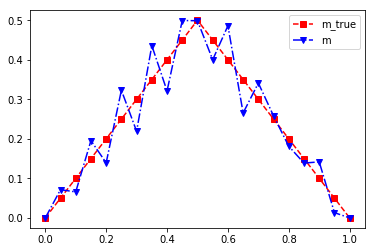

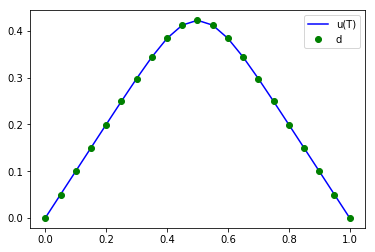

(19,) (19,)


In [2]:
def naiveSolveInv(d):
    A = assembleMatrix(d.shape[0])
    
    p_i = d.copy()
    for i in np.arange(nt):
        p = A*p_i
        p_i[:] = p
        
    return p

T = 1.0
L = 1.0
k = 0.005

nx = 20
nt = 100

noise_std_dev = 1e-4

h = L/float(nx)
dt = T/float(nt)

x = np.linspace(0.+h, L-h, nx-1) #place nx-1 equispace point in the interior of [0,L] interval
#m_true = np.power(.5,-36)*np.power(x,20)*np.power(1. - x, 16)  #smooth true initial condition
m_true = 0.5 - np.abs(x-0.5)                                    #initial condition with a corner
u_true = solveFwd(m_true)

d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

m = naiveSolveInv(d)

plot(m_true, "--rs", label = 'm_true')
plot(m, "-.bv", label = 'm')
plt.legend()
plt.show()

plot(u_true, "-b", label = 'u(T)')
plot(d, "og", label = 'd')
plt.legend()
plt.show()

print(d.shape, u_true.shape)

### Why does the naive solution fail?

Let $v_n = \sqrt{\frac{2}{L}} \sin\left( n \, \frac{\pi}{L} x \right)$ with $n=1,2,3, \ldots$, then we have that

$$ \mathcal{F} v_n = \lambda_n v_n, \quad \text{where the eigenvalues } \lambda_n = e^{-kT\left(\frac{\pi}{L} n \right)^2}. $$

**Note 1**:
- Large eigenvalues $\lambda_n$ corresponds to smooth eigenfunctions $v_n$;
- Small eigenvalues $\lambda_n$ corresponds to oscillatory eigenfuctions $v_n$.

The figure below shows that the eigenvalues $\lambda_n$ decays extremely fast, that is the matrix $F$ (discretization of the forward model $\mathcal{F}$) is extremely ill conditioned.

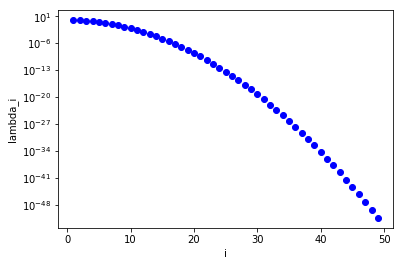

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

T = 1.0
L = 1.0
k = 0.005

i = np.arange(1,50)
lambdas = np.exp(-k*T*np.power(np.pi/L*i,2))

plt.semilogy(i, lambdas, 'ob')
plt.xlabel('i')
plt.ylabel('lambda_i')
plt.show()

**Note 2**: The functions $v_n$ ($n=1,2,3, \ldots$) form an orthonormal basis of L^2([0,1]). 

That is, every function $f \in L^2([0,1])$ can be written as

$$ f = \sum_{n=1}^\infty \alpha_n v_n, \text{ where } \alpha_n = \int_0^1 f v_n dx.$$

Consider now the noisy problem

$$ d = \mathcal{F}m_{\rm true} + \eta, $$

where
- $d$ is the data (noisy measurements)
- $\eta$ is the noise: $\eta(x) = \sum_{n=1}^\infty \eta_n v_n(x)$
- $m_{\rm true}$ is the true value of the parameter that generated the data
- $\mathcal{F}$ is the forward heat equation

Then, the naive solution to the inverse problem $\mathcal{F}m = d$ is

$$ m = \mathcal{F}^{-1}d = \mathcal{F}^{-1}\left( \mathcal{F}m_{\rm true} + \eta \right) = m_{\rm true} + \mathcal{F}^{-1} \eta = m_{\rm true} + \mathcal{F}^{-1} \sum_{n=1}^{\infty} \eta_n v_n = m_{\rm true} +  \sum_{n=1}^{\infty} \frac{\eta_n}{\lambda_n} v_n. $$

If the coefficients $\eta_n = \int_0^1 \eta(x) \, v_n(x) \, dx$ do not decay sufficiently fast with respect to the eigenvalues $\lambda_n$, then the naive solution is unstable.

This implies that oscillatory components can not reliably be reconstructed from noisy data since they correspond to small eigenvalues.

### Regularization by filtering

Remedy is to dampen the terms corresponding to small eigenvalues and write

$$ m \approx \sum_{n=1}^{\infty} \omega(\lambda_n^2)\, \lambda_n^{-1}\, \delta_n\, v_n, $$

where

- $\delta_n = \int_0^1 d(x) \, v_n(x) \, dx$ denotes the coefficients of the data $d$ in the basis $\{ v_n \}_{n=1}^\infty$;
- $\omega( \lambda_n^2)$ is a filter function that allows to drop/stabilize the terms corresponding to small $\lambda_n$.

#### Truncated Singular Value Decomposition:

$$ \omega_\alpha( \lambda^2 ) = \left\{\begin{array}{ll} 1, & \text{ if } \lambda^2 \geq \alpha \\ 0, & \text{ otherwise}\end{array}, \right.$$

where $\alpha$ is a regularization parameter.

Then, we have

$$ m_{\rm svd} = \sum_{n=1}^N \lambda_n^{-1} \delta_n\, v_n, $$

where $N$ is largest index such that $\lambda_n^2 \geq \alpha$ (assuming that $\lambda_n$ are sorted in a decreasing order).

#### Tikhonov filter:

$$ \omega_\alpha( \lambda^2 ) = \frac{\lambda^2}{\lambda^2+\alpha}, $$
where $\alpha$ is a regularization parameter. 

**NOTE**:
$\omega_\alpha( \lambda^2 )$ is close to $1$ when $\lambda \gg \alpha$, close to 0 when $\lambda \ll \alpha$).

Then we have

$$ m_{\rm tikh} = \sum_{n=1}^{\infty} \frac{\lambda_n}{\lambda_n^2+\alpha} \delta_n\, v_n, $$

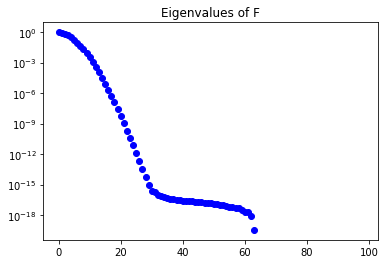

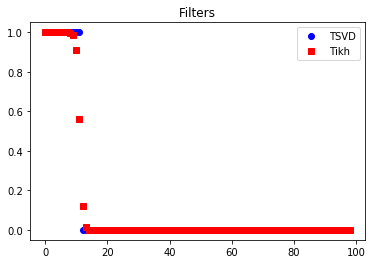

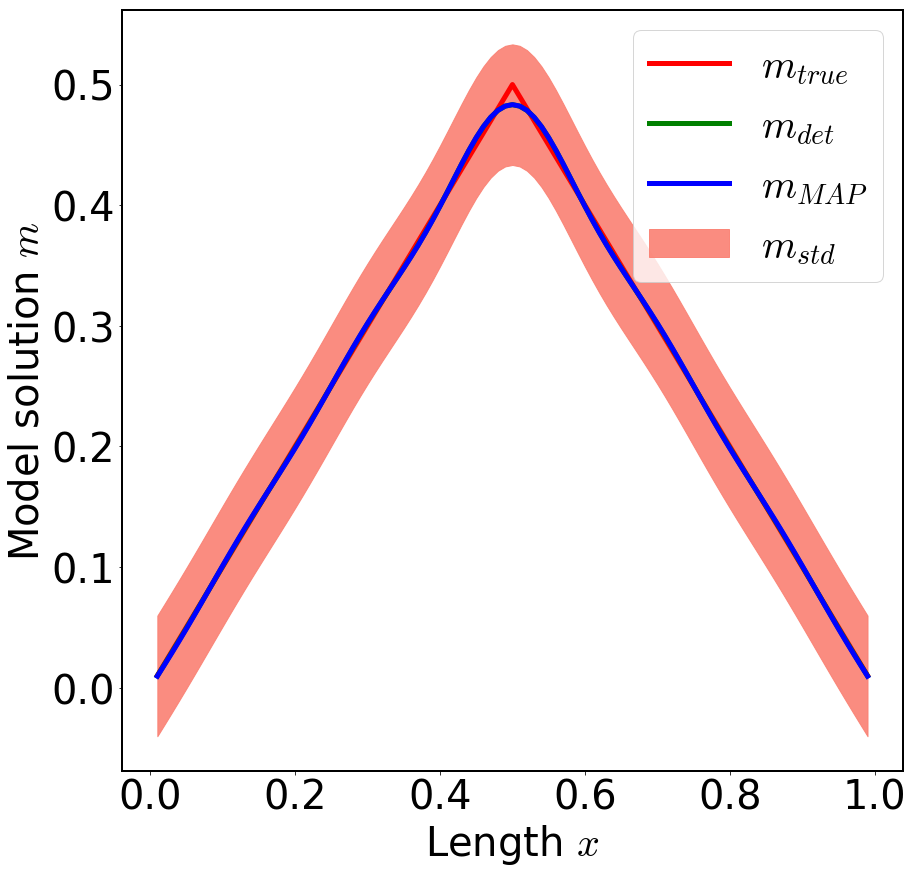

In [4]:
def computeEigendecomposition(n):
    ## Compute F as a dense matrix
    F = np.zeros((n,n))
    m_i = np.zeros(n)
    
    for i in np.arange(n):
        m_i[i] = 1.0
        F[:,i] = solveFwd(m_i)
        m_i[i] = 0.0
    
    ## solve the eigenvalue problem
    lmbda, U = np.linalg.eigh(F)
    ## sort eigenpairs in decreasing order
    lmbda[:] = lmbda[::-1]
    lmbda[lmbda < 0.] = 0.0
    U[:] = U[:,::-1]
    
    return lmbda, U 


## Setup the problem
T = 1.0
L = 1.0
k = 0.005

nx = 100
nt = 100

noise_std_dev = 0.0#1e-3

h = L/float(nx)
dt = T/float(nt)

## Compute the data d by solving the forward model
x = np.linspace(0.+h, L-h, nx-1)
#m_true = np.power(.5,-36)*np.power(x,20)*np.power(1. - x, 16)
m_true = 0.5 - np.abs(x-0.5)
u_true = solveFwd(m_true)
d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

## Compute eigenvector and eigenvalues of the discretized forward operator
lmbda, U = computeEigendecomposition(nx-1)

plt.semilogy(lmbda, 'ob')
plt.title("Eigenvalues of F")
plt.show()

# Show filters
alpha = 1.e-6
plt.plot(lmbda*lmbda >= alpha, 'ob', label="TSVD")
plt.plot(lmbda*lmbda/(lmbda*lmbda + alpha), 'sr', label="Tikh")
plt.legend()
plt.title("Filters")
plt.show()

# Compute TSVD and Tikh sol
lmbda_inv = np.zeros_like(lmbda)
lmbda_inv[lmbda >= np.sqrt(alpha)] = lmbda[lmbda >= np.sqrt(alpha)]**(-1)
m_tsvd = np.dot(U, lmbda_inv*np.dot(U.T, d))

den = lmbda*lmbda+alpha
m_tikh = np.dot(U, (lmbda/den)*np.dot(U.T, d))

mpl.rcParams.update(rcparams) 
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
ax.plot(x, m_true, "-r", lw=5, markersize=8.0, label = r'$m_{true}$')
# ax.plot(x, m_tsvd, "-b", lw=5, markersize=8.0, label = 'm_tsvd')
ax.plot(x, m_tikh, "-g", lw=5, markersize=8.0, label = r'$m_{det}$')#m_{tikh}
ax.plot(x, m_tsvd, "-b", lw=5, markersize=8.0, label = r'$m_{MAP}$')
# ax.plot(m_tikh+0.05, ".", label = '$95\%$ credibility bounds')
# ax.plot(m_tikh-0.05, ".")
ax.fill_between(x, (m_tikh-0.05), (m_tikh+0.05),
                 color="salmon", alpha=0.9, label=r"$m_{std}$")
ax.set_xlabel(r"Length $x$", size=40)
ax.set_ylabel(r"Model solution $m$", size=40)
ax.tick_params(labelsize=40)
ax.xaxis.offsetText.set_fontsize(40)
ax.yaxis.offsetText.set_fontsize(40)
# plt.title("Solution")
ax.legend(loc='best', prop={'size': 40})
plt.show()

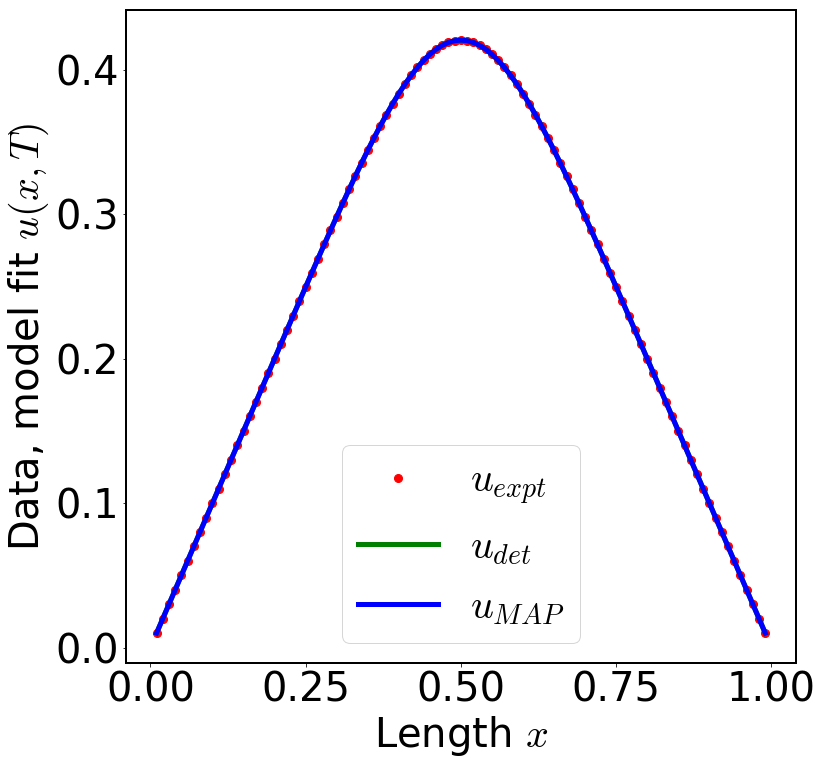

In [5]:
##Model fit
u_tikh = solveFwd(m_tikh)
u_tsvd = solveFwd(m_tsvd)

mpl.rcParams.update(rcparams) 
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.plot(x, d, "or", lw=5, markersize=8.0, label = r'$u_{expt}$')
# ax.plot(x, u_tsvd, "-b", lw=5, markersize=8.0, label = 'u_tsvd')
ax.plot(x, u_tikh, "-g", lw=5, markersize=8.0, label = r'$u_{det}$')#m_{tikh}
ax.plot(x, u_tsvd, "-b", lw=5, markersize=8.0, label = r'$u_{MAP}$')
ax.set_xlabel(r"Length $x$", size=40)
ax.set_ylabel(r"Data, model fit $u(x, T)$", size=40)
# plt.title("Data, model fit")
ax.tick_params(labelsize=40)
ax.xaxis.offsetText.set_fontsize(40)
ax.yaxis.offsetText.set_fontsize(40)
# plt.title("Solution")
ax.legend(loc='best', prop={'size': 40})
plt.show()

Copyright &copy; 2017, The University of Texas at Austin & University of California, Merced. All Rights reserved. See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.